In [ ]:
from lib.admin_areas import get_region_avail_dates

ADMIN_ID = "CHE"

dates = get_region_avail_dates(ADMIN_ID)
dates

['2018-06-29', '2018-08-02', '2018-09-07', '2018-11-16']

In [2]:
from datetime import date, timedelta

LJ_DATE = date.fromisoformat("2018-08-02")
BM_DATE = LJ_DATE + timedelta(days=1)

LJ_DATE, BM_DATE

(datetime.date(2018, 8, 2), datetime.date(2018, 8, 3))

In [4]:
from blackmarble.types import Product

from lib.admin_areas import get_region_gdf
from lib.bm import bm_download

gdf = get_region_gdf(ADMIN_ID, resolution="10m")

BM_VARIABLE = "DNB_At_Sensor_Radiance_500m"

bm_data = bm_download(gdf, BM_DATE, Product.VNP46A1, variable=BM_VARIABLE)
bm_data

GETTING MANIFEST...: 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


QUEUEING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

COLLATING RESULTS | Processing...: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


<xarray.Dataset> Size: 4MB
Dimensions:                      (x: 1083, y: 475, time: 1)
Coordinates:
  * x                            (x) float64 9kB 5.956 5.96 ... 10.46 10.46
  * y                            (y) float64 4kB 47.8 47.79 ... 45.83 45.82
  * time                         (time) datetime64[ns] 8B 2018-08-03
Data variables:
    DNB_At_Sensor_Radiance_500m  (time, y, x) float64 4MB nan nan ... nan nan
Attributes: (12/26)
    AlgorithmType:                     b'OPS'
    EndTime:                           b'2018-08-03 23:59:59'
    HorizontalTileNumber:              b'19'
    identifier_product_doi:            b'10.5067/VIIRS/VNP46A1.001'
    identifier_product_doi_authority:  b'http://dx.doi.org'
    InputPointer:                      b'/MODAPSops4/archive/f7066/running/VN...
    ...                                ...
    StartTime:                         b'2018-08-03 00:00:00'
    TileID:                            b'61019004'
    VerticalTileNumber:                b'04'
    AREA_OR_POINT:                     Area
    scale_factor:                      1.0
    add_offset:                        0.0

In [7]:
radiance = bm_data.sel(time=BM_DATE.isoformat())[BM_VARIABLE]
radiance

<xarray.DataArray 'DNB_At_Sensor_Radiance_500m' (y: 475, x: 1083)> Size: 4MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(475, 1083))
Coordinates:
  * x        (x) float64 9kB 5.956 5.96 5.965 5.969 ... 10.45 10.46 10.46 10.46
  * y        (y) float64 4kB 47.8 47.79 47.79 47.79 ... 45.84 45.83 45.83 45.82
    time     datetime64[ns] 8B 2018-08-03
Attributes:
    units:    nW/cm²sr

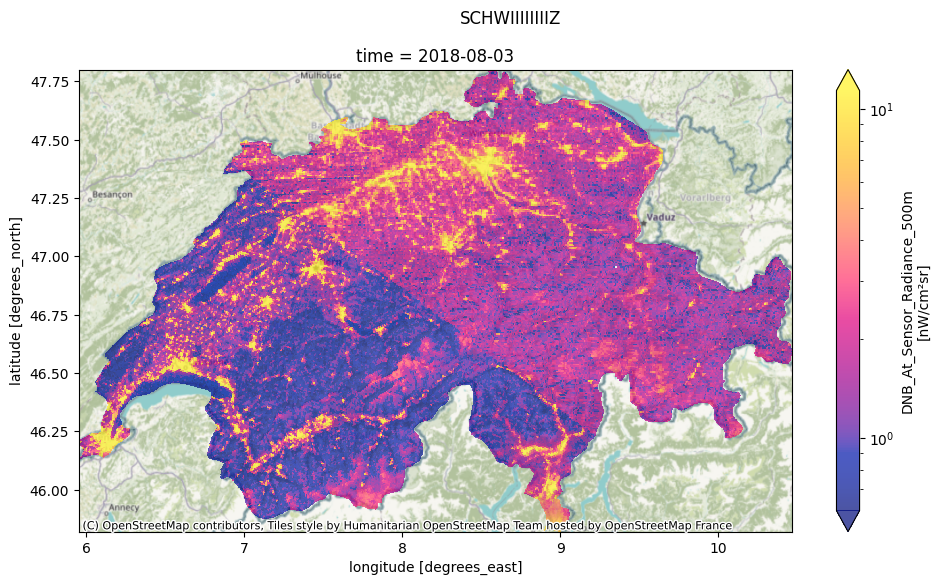

In [25]:
import colorcet as cc
import contextily as cx
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(figsize=(11.5, 6))
fig.suptitle("SCHWIIIIIIIIZ")
radiance.plot.pcolormesh(ax=ax, robust=True, cmap=cc.cm.bmy, alpha=0.7, norm=LogNorm())
cx.add_basemap(ax=ax, crs=gdf.crs.to_string())

In [18]:
import os

import rioxarray
import xarray as xr
from pqdm.threads import pqdm
from rasterio.io import MemoryFile

from lib.admin_areas import get_region_avail_dates, get_region_gdf, get_region_meta
from lib.geotiff import merge_geotiffs
from lib.lj import lj_download_metadata, lj_download_tile

# Download LJ
lj_download_metadata()

region_meta = get_region_meta()
region_meta

Metadata already downloaded, skipping... (use --force to re-download)
Metadata successfully extracted


,country,date,tile_name
0,MMR,2019-03-13,LuoJia1-01_LR201903152987_20190313154405_HDR_0004
1,MMR,2018-10-04,LuoJia1-01_LR201810054768_20181004154119_HDR_0003
2,MMR,2018-11-02,LuoJia1-01_LR201811031563_20181102155005_HDR_0050
3,MMR,2018-11-27,LuoJia1-01_LR201811285712_20181127155749_HDR_0019
4,MMR,2018-11-19,LuoJia1-01_LR201811208517_20181119160159_HDR_0005
...,...,...,...
13547,ISL,2018-11-01,LuoJia1-01_LR201811022594_20181101220745_HDR_0054
13548,ISL,2018-11-01,LuoJia1-01_LR201811022594_20181101220730_HDR_0051
13549,ISL,2018-11-01,LuoJia1-01_LR201811022594_20181101220740_HDR_0053
13550,ISL,2018-11-01,LuoJia1-01_LR201811022594_20181101220735_HDR_0052


In [ ]:
region_meta = region_meta[(region_meta["country"] == ADMIN_ID) & (region_meta["date"] == LJ_DATE.isoformat())]
region_meta

,country,date,tile_name
12196,CHE,2018-08-02,LuoJia1-01_LR201808032805_20180802213830_HDR_0037
12198,CHE,2018-08-02,LuoJia1-01_LR201808032805_20180802213825_HDR_0036
12200,CHE,2018-08-02,LuoJia1-01_LR201808032805_20180802213835_HDR_0038
12201,CHE,2018-08-02,LuoJia1-01_LR201808032805_20180802213900_HDR_0043
12207,CHE,2018-08-02,LuoJia1-01_LR201808032805_20180802213910_HDR_0045
12221,CHE,2018-08-02,LuoJia1-01_LR201808032805_20180802213920_HDR_0047
12228,CHE,2018-08-02,LuoJia1-01_LR201808032805_20180802213905_HDR_0044
12229,CHE,2018-08-02,LuoJia1-01_LR201808032805_20180802213845_HDR_0040
12230,CHE,2018-08-02,LuoJia1-01_LR201808032805_20180802213820_HDR_0035
12233,CHE,2018-08-02,LuoJia1-01_LR201808032805_20180802213850_HDR_0041


In [20]:
relevant_tiles = region_meta["tile_name"].tolist()
pqdm(relevant_tiles, lj_download_tile, n_jobs=os.cpu_count() or 1, exception_behaviour="immediate")

geotiff_data, pc02_lj, pc98_lj, lj_geometry = merge_geotiffs(relevant_tiles)
with MemoryFile(geotiff_data) as memfile:
    with memfile.open() as dataset:
        lj_xarr: xr.DataArray = rioxarray.open_rasterio(dataset)  # type: ignore

lj_xarr = lj_xarr.sel(band=1)
lj_xarr

QUEUEING TASKS | :   0%|          | 0/14 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/14 [00:00<?, ?it/s]

Tile successfully extracted
Tile successfully extracted
Tile successfully extracted
Tile successfully extracted
Tile successfully extracted
Tile successfully extracted
Tile successfully extracted
Tile successfully extracted
Tile successfully extracted
Tile successfully extracted
Tile successfully extracted
Tile successfully extracted
Tile successfully extracted
Tile successfully extracted


COLLECTING RESULTS | :   0%|          | 0/14 [00:00<?, ?it/s]

/home/federico/.miniforge3/envs/infrared-marble/lib/python3.12/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


<xarray.DataArray (y: 5245, x: 4618)> Size: 97MB
[24221410 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 37kB 2.982 2.983 2.984 2.986 ... 8.758 8.759 8.76
  * y            (y) float64 42kB 49.9 49.9 49.9 49.9 ... 43.34 43.34 43.34
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0

(array([1.4516707e+07, 1.8900000e+02, 4.3000000e+01, 1.7000000e+01,
        8.0000000e+00, 4.0000000e+00, 6.0000000e+00, 3.0000000e+00,
        3.0000000e+00, 2.0000000e+00]),
 array([0.        , 0.01238632, 0.02477264, 0.03715895, 0.04954527,
        0.06193159, 0.07431791, 0.08670422, 0.09909055, 0.11147687,
        0.12386318]),
 <BarContainer object of 10 artists>)

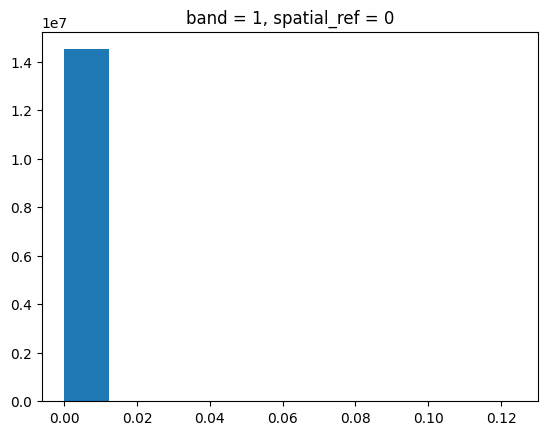

In [27]:
lj_xarr.plot.hist()

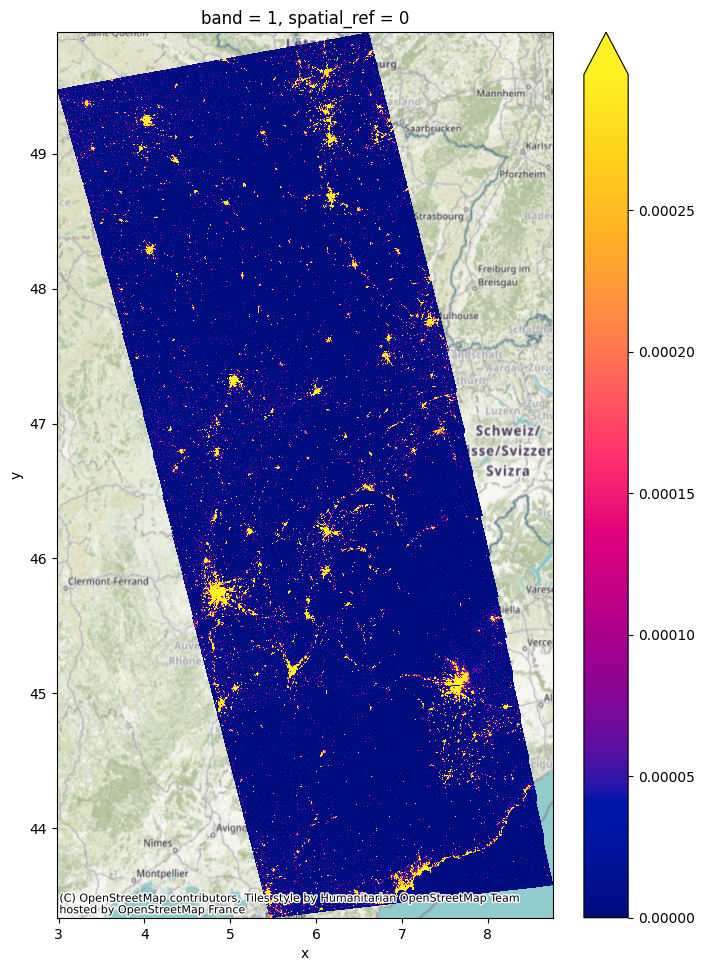

In [28]:
import colorcet as cc

fix, ax = plt.subplots(figsize=(8, 11.5))
lj_xarr.plot.pcolormesh(robust=True, cmap=cc.cm.bmy)
cx.add_basemap(ax, crs=gdf.crs.to_string())

In [32]:
res = radiance - lj_xarr
res.x

<xarray.DataArray 'x' (x: 0)> Size: 0B
array([], dtype=float64)
Coordinates:
  * x            (x) float64 0B 
    time         datetime64[ns] 8B 2018-08-03
    band         int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    axis:           X
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east